In [110]:
import argparse
import math
import time
import dill as pickle
from tqdm import tqdm
import numpy as np
import random
import os

import torch
import torch.nn.functional as F
import torch.optim as optim
from transformer.Optim import ScheduledOptim
from torch.utils.data import Dataset, DataLoader ,random_split
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


# DataLoader

In [93]:
#Created a dataloader to generate sine/cos/ and target tan waves.
class WaveDataset(Dataset):
    def __init__(self, n_samples=1000):
        self.n_samples = n_samples
        self.x = np.linspace(-2 * np.pi, 2 * np.pi, n_samples)
        
        # Generate sine, cosine, and tangent waves
        self.sine_wave = np.sin(self.x)
        self.cosine_wave = np.cos(self.x)
        self.tan_wave = np.tan(self.x)        
        self.tan_wave = np.clip(self.tan_wave, -10, 10)
        
        # Stack sine and cosine as input features
        self.inputs = np.stack([self.sine_wave, self.cosine_wave], axis=1)
        self.target = self.tan_wave.reshape(-1, 1)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return torch.tensor(self.inputs[index], dtype=torch.float32), torch.tensor(self.target[index], dtype=torch.float32)


# Model

In [94]:
# Defined the Transformer model with only required number of parameters
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=64, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers)
        self.output_projection = nn.Linear(d_model, output_dim)
    
    def forward(self, src):
        src = self.input_projection(src)
        transformer_output = self.transformer(src.unsqueeze(0), src.unsqueeze(0))
        output = self.output_projection(transformer_output.squeeze(0))
        return output


# helper function

In [95]:
#Modified dataloder for wave functions
def prepare_dataloader(opt, device):

    batch_size = opt.batch_size
    sequence_length = opt.sequence_length  # Define the length of the sequence

    dataset = WaveDataset(n_samples=sequence_length)
    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(dataset))  # 80% for training
    val_size = len(dataset) - train_size   # 20% for validation
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoader for both training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [160]:
def train_epoch(model, training_data, optimizer, device):
    model.train()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    criterion = nn.MSELoss()

    for batch_inputs, batch_targets in training_data:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        
        output = model(batch_inputs)
        loss = criterion(output, batch_targets)

        total_loss += loss.item() * batch_inputs.size(0)
        
        # Check how many predictions exactly match the targets
        predicted = output.detach().numpy()
        actual = batch_targets.numpy()
        correct_predictions += np.sum(np.isclose(predicted, actual, atol=1e-2))
        total_samples += batch_targets.size(0)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step_and_update_lr()
    
    # Compute average loss
    avg_loss = total_loss / total_samples
    
    # Compute accuracy as the percentage of exactly correct samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [161]:
def eval_epoch(model, validation_data, device , plot_results = True):
    ''' Epoch operation in evaluation phase for regression task '''

    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predicted = []
    all_actual = []

    criterion = nn.MSELoss()

    with torch.no_grad():
        for batch_inputs, batch_targets in validation_data:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            output = model(batch_inputs)

            # Compute loss
            loss = criterion(output, batch_targets)
            total_loss += loss.item()

            # Store predictions and actual values for plotting
            all_predicted.append(output.detach().cpu().numpy())
            all_actual.append(batch_targets.cpu().numpy())

            # Calculate accuracy by counting the number of "correct" predictions
            predicted = output.detach().cpu().numpy()
            actual = batch_targets.cpu().numpy()
            correct_predictions += np.sum(np.isclose(predicted, actual, atol=1e-2))
            total_samples += batch_targets.size(0)

    if plot_results:
        all_predicted = np.concatenate(all_predicted)
        all_actual = np.concatenate(all_actual)
        plt.figure(figsize=(12, 6))
        plt.plot(all_actual, label='Actual Target Values')
        plt.plot(all_predicted, label='Predicted Target Values', linestyle='--')
        plt.legend()
        plt.title('Actual vs Predicted Values during Validation')
        plt.xlabel('Sample Index')
        plt.ylabel('Target Value')
        plt.show()
    
    loss_per_sample = total_loss / len(validation_data)
    accuracy = correct_predictions / total_samples

    return loss_per_sample, accuracy

In [162]:
def train(model, training_data, validation_data, optimizer, device, opt):
    ''' Start training '''

    # Use tensorboard to plot curves, e.g. perplexity, accuracy, learning rate
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    #valid_accus = []
    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu = train_epoch(model, training_data, optimizer, device)
        train_ppl = math.exp(min(train_loss, 100))
        # Current learning rate
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]
        checkpoint = {
            'epoch': epoch_i,
            'model_state_dict': model.state_dict()
        }

        # Determine the filename based on the save mode
        if opt.save_mode == 'all':
            # Save all models with validation accuracy in the filename
            model_name = f'model_accu_{100 * valid_loss:.3f}.chkpt'
            torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
        elif opt.save_mode == 'best':
            # Save the best model based on validation loss
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)


In [164]:
#modified main function to run in jupyter notebook
def main():
    ''' 
    Main function to set up and run the model training
    '''

    # Define options directly
    class Opt:
        def __init__(self):
            self.batch_size = 32
            self.sequence_length = 1000
            self.epoch = 20
            self.d_model = 64
            self.n_head = 4
            self.num_layers = 2
            self.output_dir = 'output'
            self.use_tb = False
            self.save_mode = 'best'
            self.lr_mul = 2.0
            self.n_warmup_steps = 4000


    # Set up options and device
    opt = Opt()
    device = torch.device('cuda' if torch.cuda.is_available() and not opt.no_cuda else 'cpu')

    #========= Loading Dataset =========#
    train_loader, val_loader = prepare_dataloader(opt, device)



    #model is defined with the input and the output size
    model = TransformerModel(input_dim=2, output_dim=1)

    optimizer = ScheduledOptim(
        optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)
    

    train(model, train_loader, val_loader, optimizer, device, opt)


[Info] Training performance will be written to file: output/train.log and output/valid.log
[ Epoch 0 ]
  - (Training)   ppl:  210030.08184, accuracy: 0.375 %, lr:  0.00002, elapse: 0.010 min


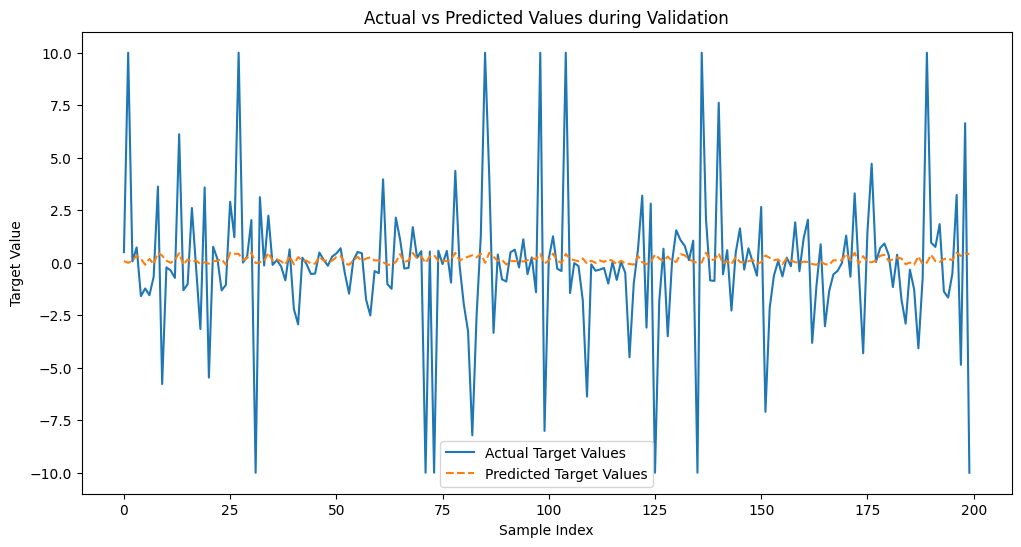

  - (Validation) ppl:  239630.41186, accuracy: 0.000 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]
  - (Training)   ppl:  144404.50004, accuracy: 0.375 %, lr:  0.00005, elapse: 0.010 min


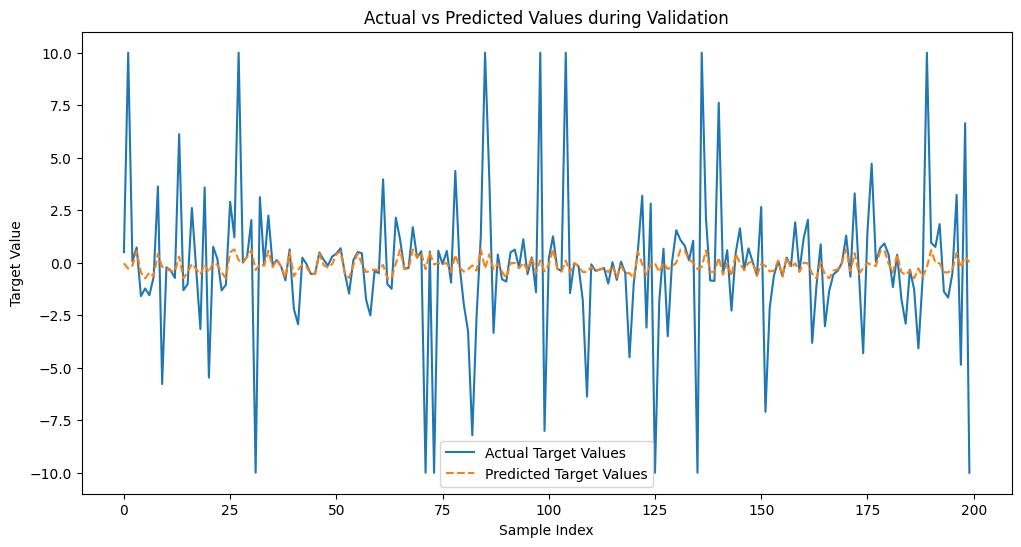

  - (Validation) ppl:  105927.73698, accuracy: 3.000 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]
  - (Training)   ppl:  60575.01120, accuracy: 1.125 %, lr:  0.00007, elapse: 0.011 min


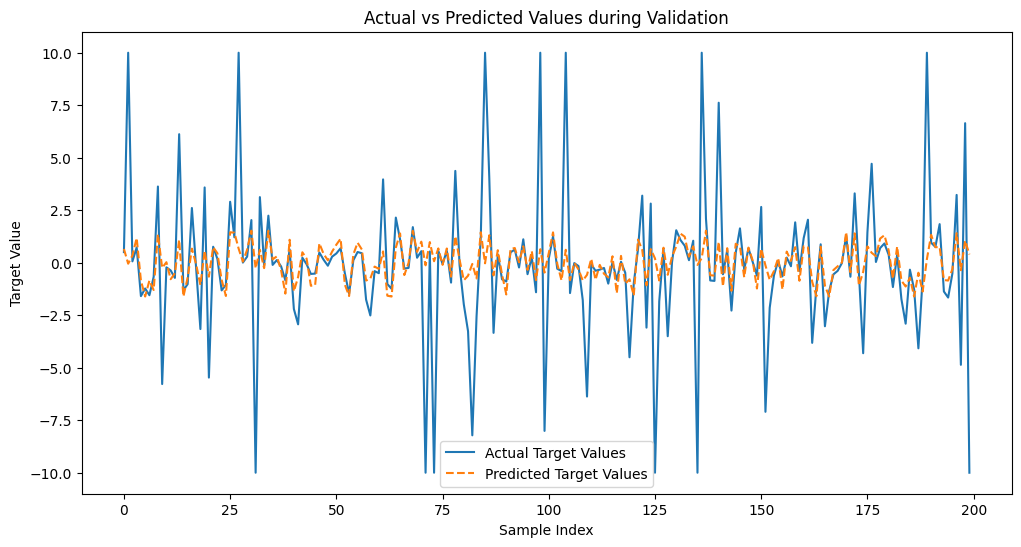

  - (Validation) ppl:  38622.93580, accuracy: 0.000 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]
  - (Training)   ppl:  20064.54008, accuracy: 0.875 %, lr:  0.00010, elapse: 0.011 min


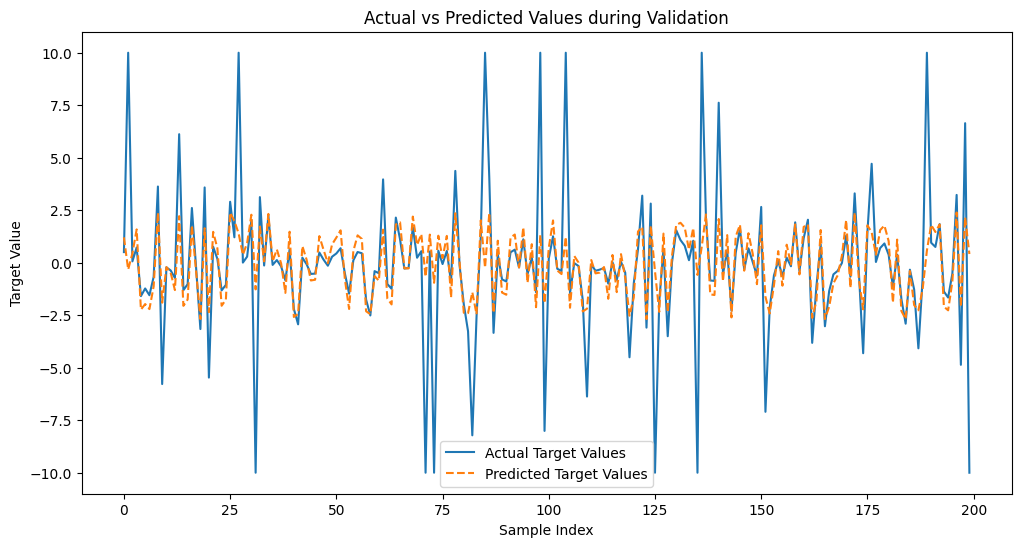

  - (Validation) ppl:  4580.45000, accuracy: 1.000 %, lr:  0.00010, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]
  - (Training)   ppl:  5426.54299, accuracy: 0.625 %, lr:  0.00012, elapse: 0.011 min


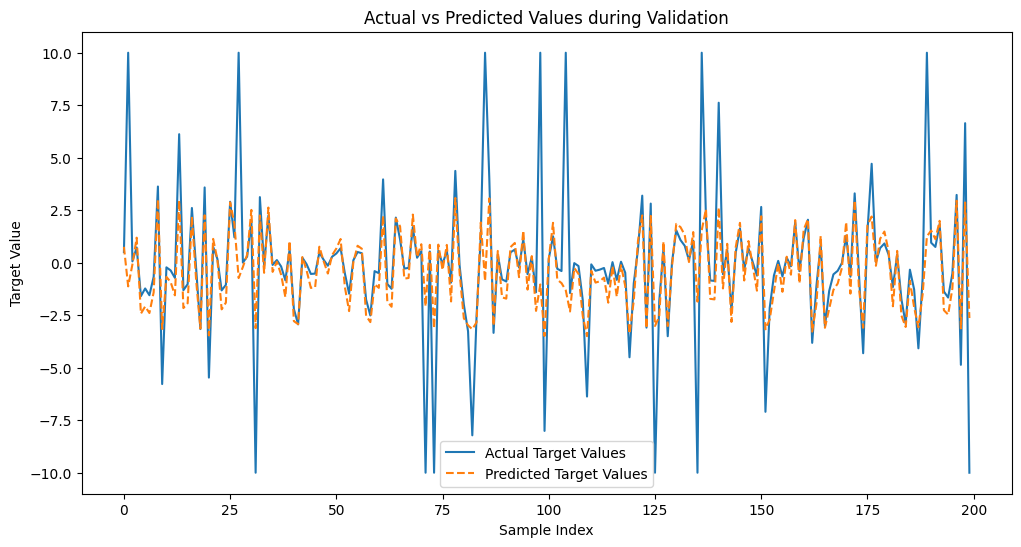

  - (Validation) ppl:  820.67711, accuracy: 0.500 %, lr:  0.00012, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]
  - (Training)   ppl:  2221.28346, accuracy: 1.625 %, lr:  0.00015, elapse: 0.011 min


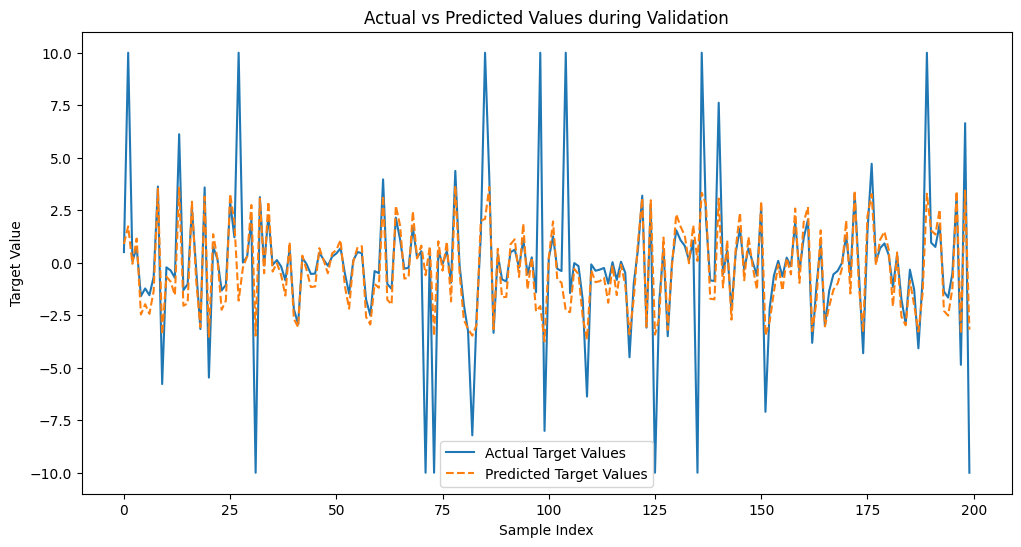

  - (Validation) ppl:  463.98101, accuracy: 0.500 %, lr:  0.00015, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]
  - (Training)   ppl:  511.94457, accuracy: 1.250 %, lr:  0.00017, elapse: 0.009 min


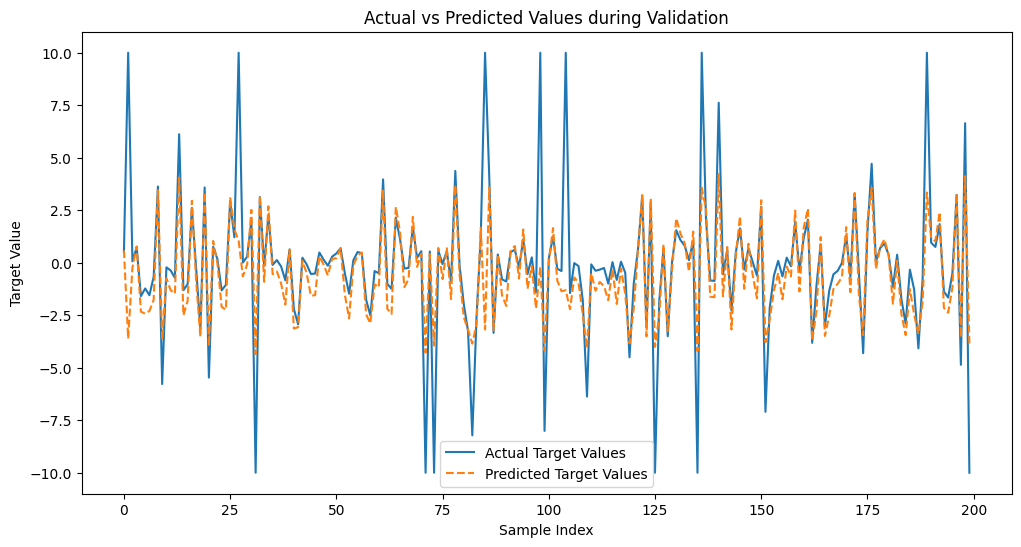

  - (Validation) ppl:  278.95142, accuracy: 0.000 %, lr:  0.00017, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]
  - (Training)   ppl:  353.18819, accuracy: 1.375 %, lr:  0.00020, elapse: 0.010 min


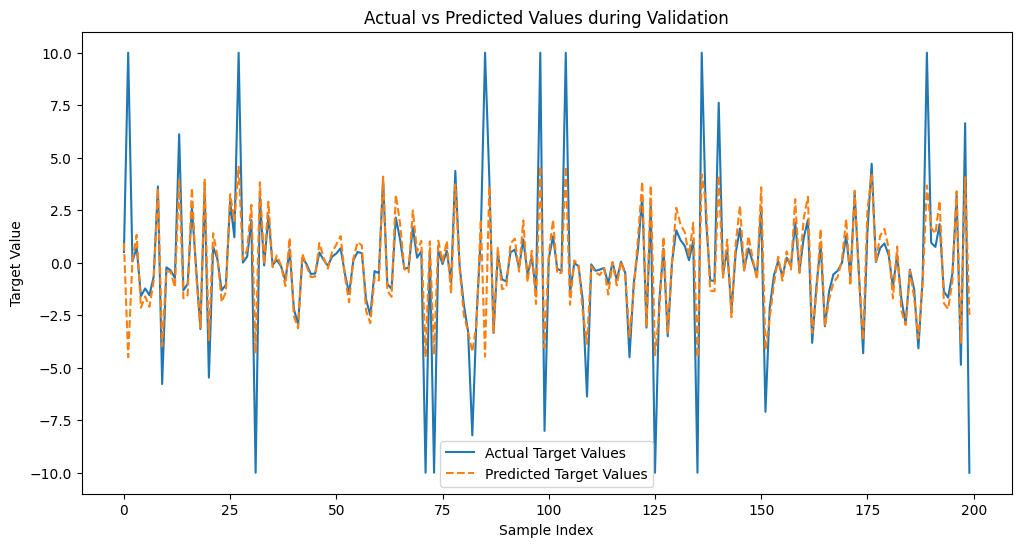

  - (Validation) ppl:  142.04841, accuracy: 2.500 %, lr:  0.00020, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]
  - (Training)   ppl:  165.11577, accuracy: 1.125 %, lr:  0.00022, elapse: 0.013 min


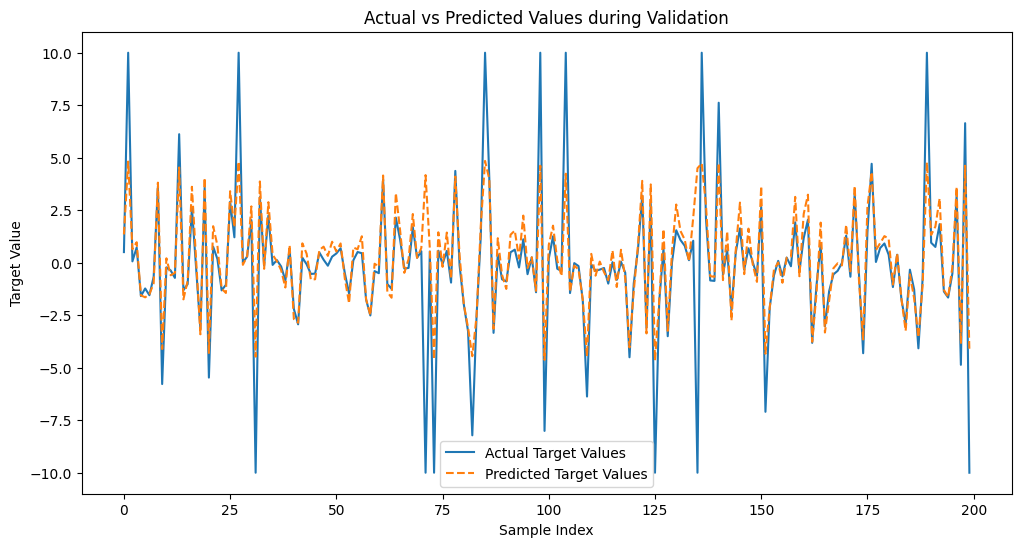

  - (Validation) ppl:  71.09880, accuracy: 2.500 %, lr:  0.00022, elapse: 0.005 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]
  - (Training)   ppl:  3445.23281, accuracy: 0.750 %, lr:  0.00025, elapse: 0.011 min


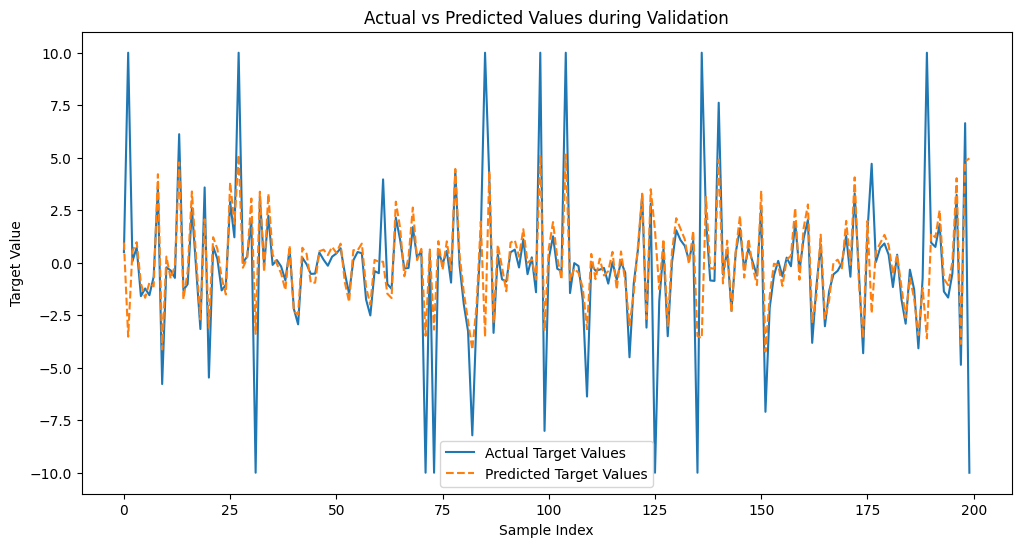

  - (Validation) ppl:  20528.49836, accuracy: 0.000 %, lr:  0.00025, elapse: 0.004 min
[ Epoch 10 ]
  - (Training)   ppl:  829.00058, accuracy: 0.750 %, lr:  0.00027, elapse: 0.010 min


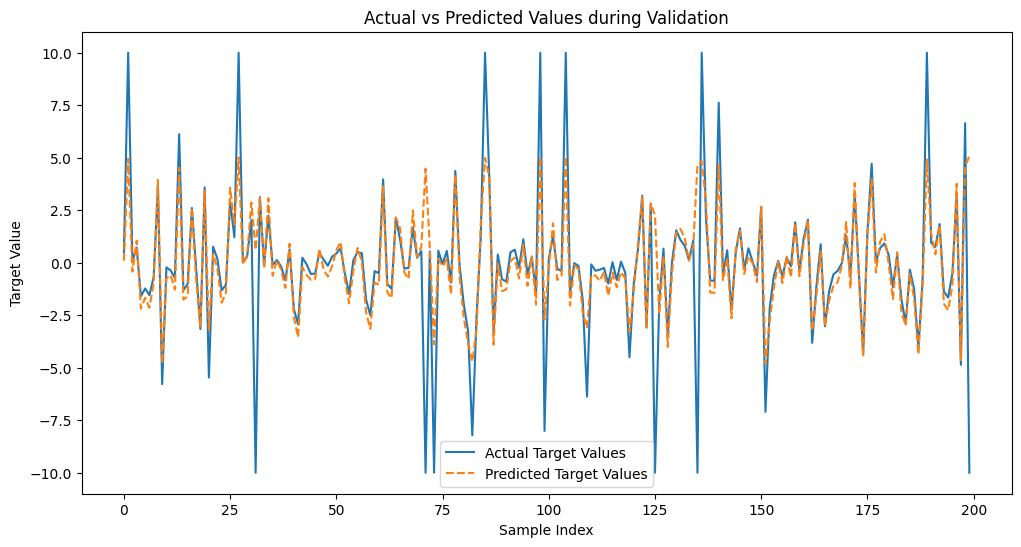

  - (Validation) ppl:  5774.74141, accuracy: 1.000 %, lr:  0.00027, elapse: 0.004 min
[ Epoch 11 ]
  - (Training)   ppl:  162.19582, accuracy: 1.625 %, lr:  0.00030, elapse: 0.011 min


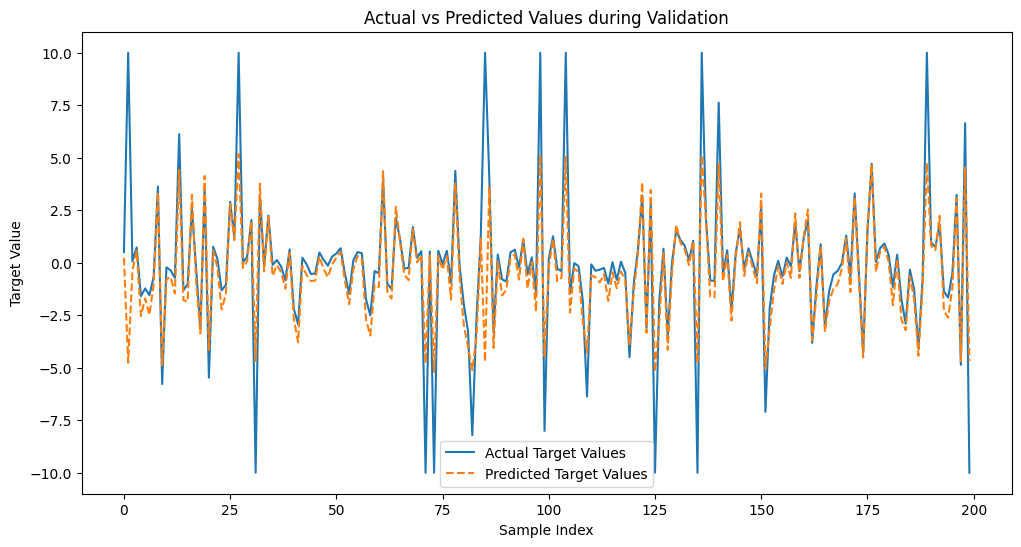

  - (Validation) ppl:  58.52447, accuracy: 0.000 %, lr:  0.00030, elapse: 0.005 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]
  - (Training)   ppl:  121.90215, accuracy: 1.000 %, lr:  0.00032, elapse: 0.010 min


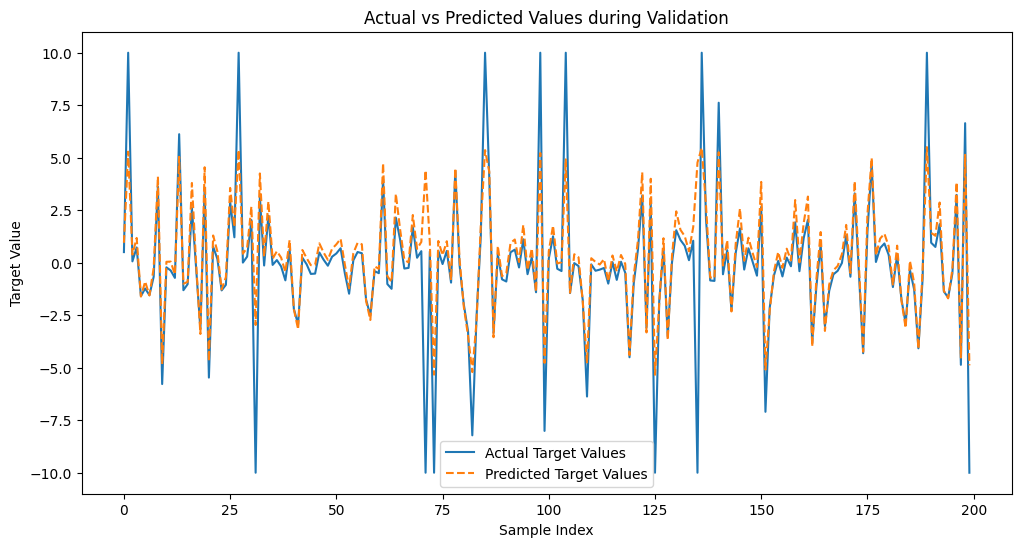

  - (Validation) ppl:  47.32904, accuracy: 0.000 %, lr:  0.00032, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]
  - (Training)   ppl:  208.33509, accuracy: 1.000 %, lr:  0.00035, elapse: 0.012 min


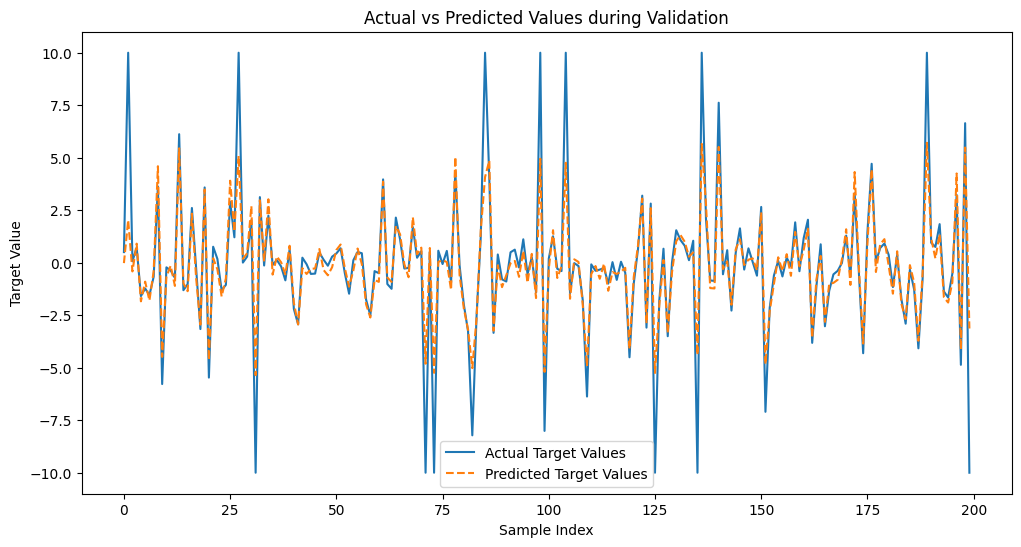

  - (Validation) ppl:  14.44632, accuracy: 0.500 %, lr:  0.00035, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]
  - (Training)   ppl:  133.55093, accuracy: 1.500 %, lr:  0.00037, elapse: 0.011 min


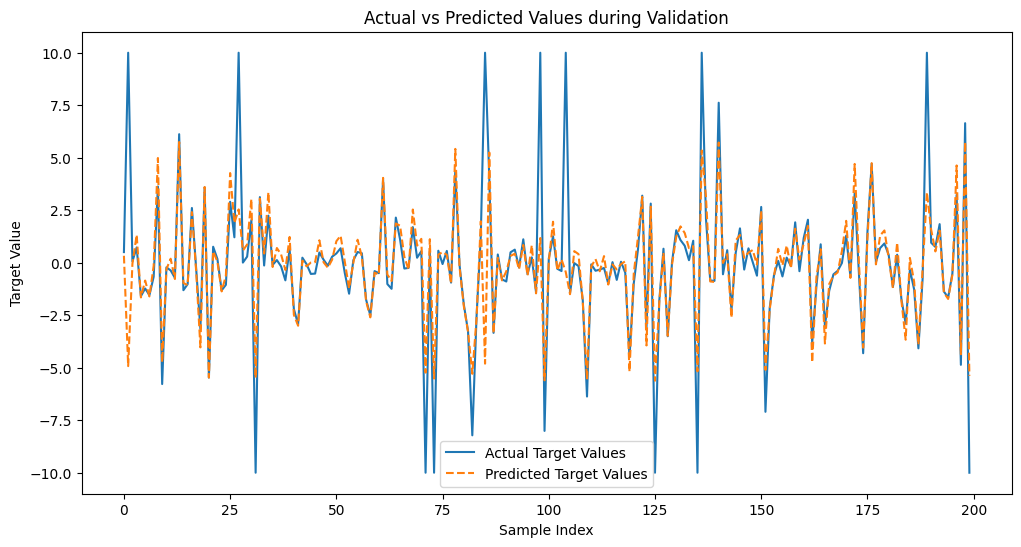

  - (Validation) ppl:  93.56773, accuracy: 0.500 %, lr:  0.00037, elapse: 0.004 min
[ Epoch 15 ]
  - (Training)   ppl:  171.68166, accuracy: 1.375 %, lr:  0.00040, elapse: 0.011 min


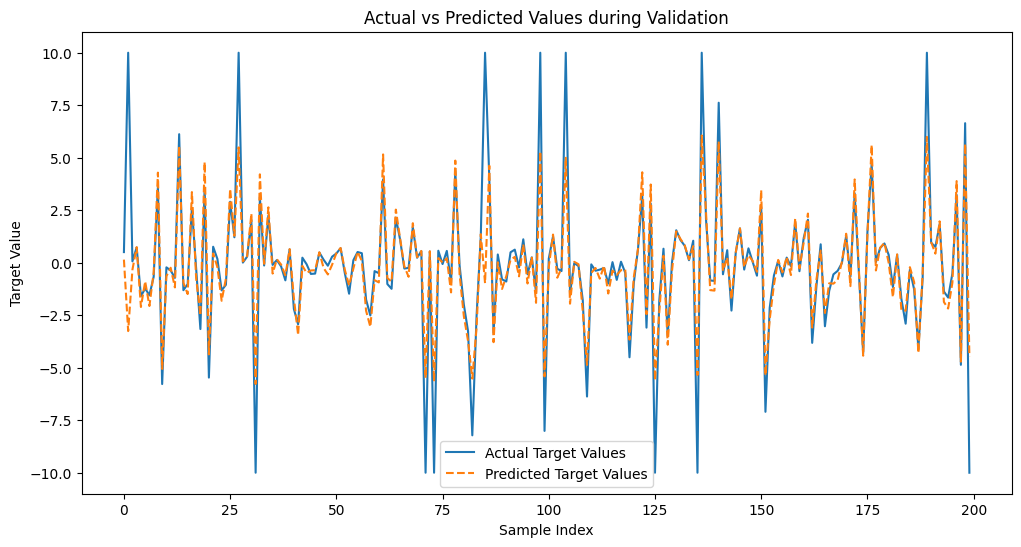

  - (Validation) ppl:  20.64487, accuracy: 1.500 %, lr:  0.00040, elapse: 0.004 min
[ Epoch 16 ]
  - (Training)   ppl:  138.71408, accuracy: 1.875 %, lr:  0.00042, elapse: 0.011 min


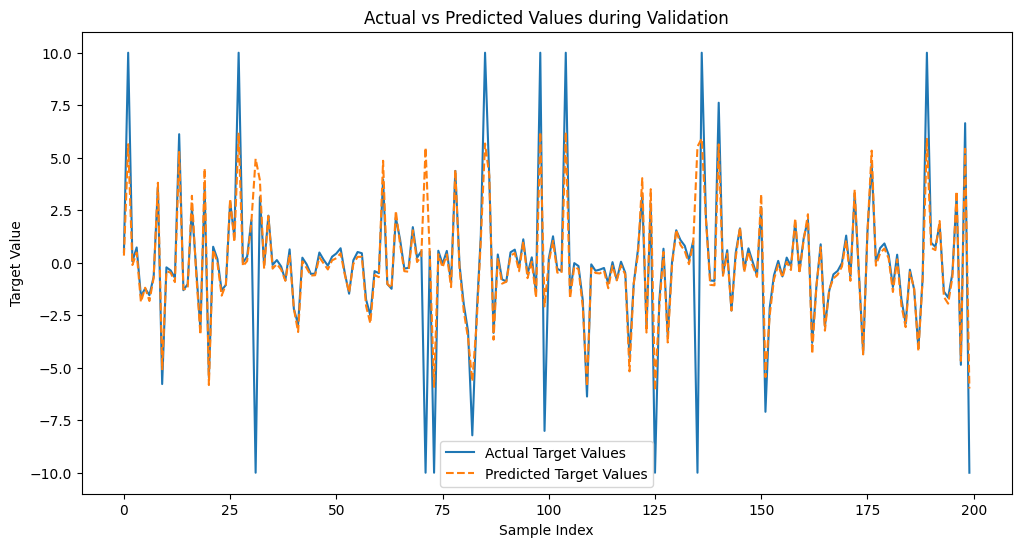

  - (Validation) ppl:  80.54931, accuracy: 1.500 %, lr:  0.00042, elapse: 0.004 min
[ Epoch 17 ]
  - (Training)   ppl:  1038.35862, accuracy: 2.000 %, lr:  0.00044, elapse: 0.012 min


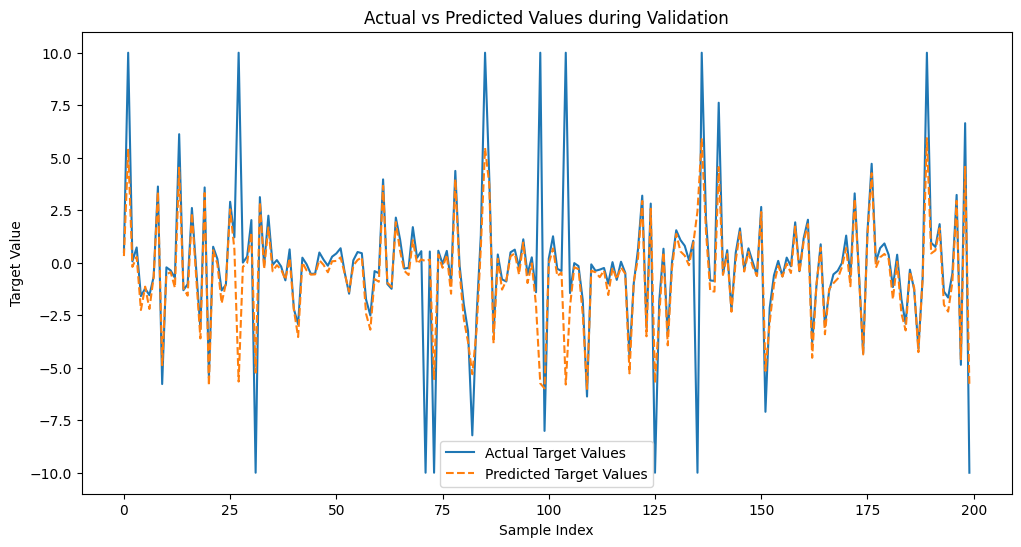

  - (Validation) ppl:  300.66387, accuracy: 1.000 %, lr:  0.00044, elapse: 0.005 min
[ Epoch 18 ]
  - (Training)   ppl:  376.24084, accuracy: 1.250 %, lr:  0.00047, elapse: 0.011 min


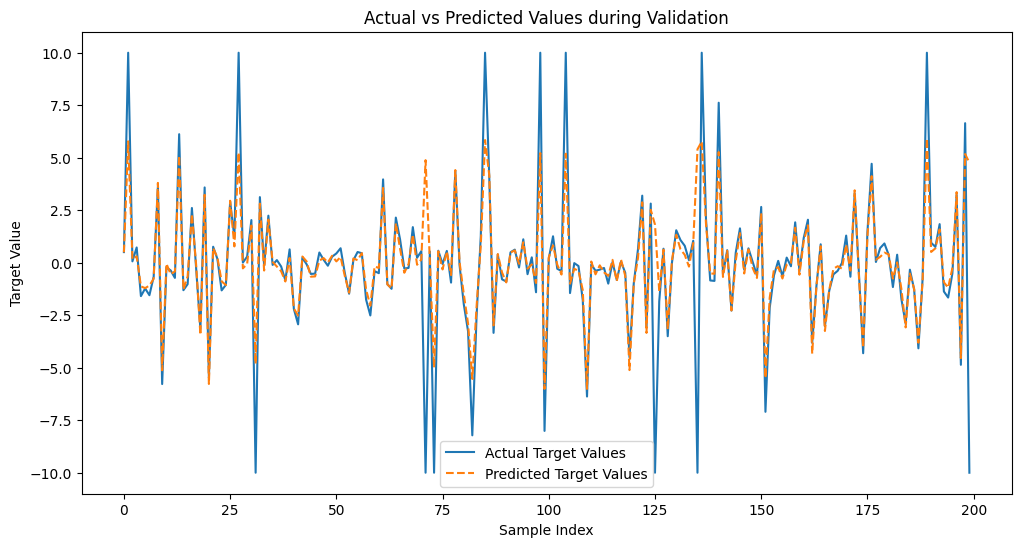

  - (Validation) ppl:  2033.38028, accuracy: 2.500 %, lr:  0.00047, elapse: 0.004 min
[ Epoch 19 ]
  - (Training)   ppl:  601.58967, accuracy: 1.500 %, lr:  0.00049, elapse: 0.012 min


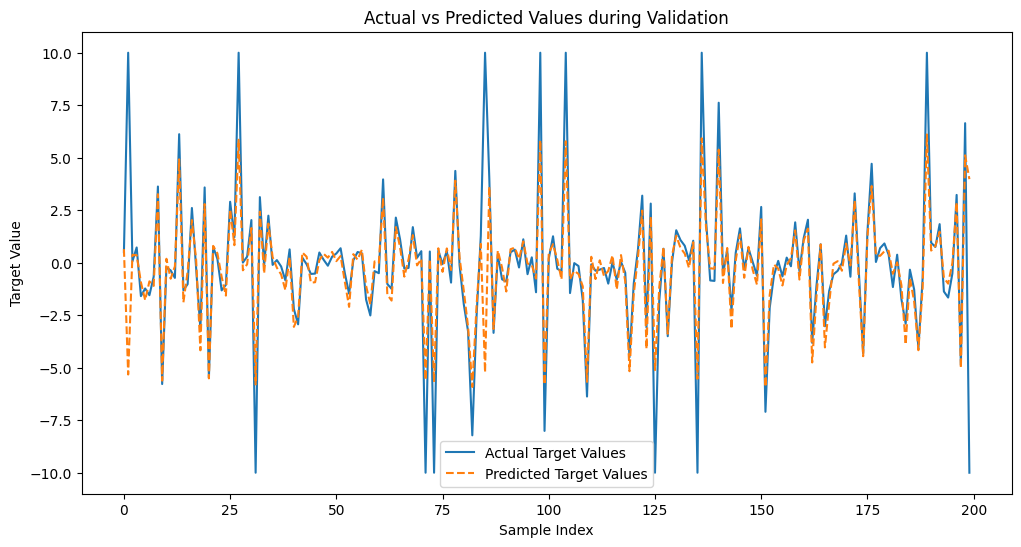

  - (Validation) ppl:  823.39505, accuracy: 0.500 %, lr:  0.00049, elapse: 0.004 min


In [165]:
main()